# Importing Libraries and Creating Dataset

In [ ]:
import tensorflow as tf
import keras
from PIL import Image,ImageFilter
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2


train_dir = "/content/data"  # Setting training data path

for img in os.listdir( train_dir + "/original_images"):
  print(img)
  img_array = cv2.imread(train_dir + "/original_images/" + img)
  # print(img_array)
  img_array = cv2.resize(img_array, (128,128))
  print(img_array.shape)
  lr_img_array = cv2.resize(img_array,(32,32))
  print(lr_img_array.shape) 
  cv2.imwrite("/content/data/hr_images/" + img, img_array)    #Create Higher Resolution images
  cv2.imwrite("/content/data/lr_images/"+ img, lr_img_array)  #creat Lower Resolution images

area1_00232_f0_a90.png
(128, 128, 3)
(32, 32, 3)
vegetation_00006_a0.png
(128, 128, 3)
(32, 32, 3)
building2_00010_a0.png
(128, 128, 3)
(32, 32, 3)
area1_00237_f0_a90.png
(128, 128, 3)
(32, 32, 3)
farm2_00006_a0.png
(128, 128, 3)
(32, 32, 3)
area1_00236_f0_a180.png
(128, 128, 3)
(32, 32, 3)
area1_00236_f1_a180.png
(128, 128, 3)
(32, 32, 3)
area1_00232_f0_a180.png
(128, 128, 3)
(32, 32, 3)
farm2_00005_a0.png
(128, 128, 3)
(32, 32, 3)
area1_00226_f1_a180.png
(128, 128, 3)
(32, 32, 3)
vegetation_00017_a0.png
(128, 128, 3)
(32, 32, 3)
area1_00228_f1_a0.png
(128, 128, 3)
(32, 32, 3)
area1_00237_f0_a270.png
(128, 128, 3)
(32, 32, 3)
area1_00232_f1_a270.png
(128, 128, 3)
(32, 32, 3)
vegetation2_00002_a0.png
(128, 128, 3)
(32, 32, 3)
vegetation2_00015_a0.png
(128, 128, 3)
(32, 32, 3)
area1_00233_f1_a0.png
(128, 128, 3)
(32, 32, 3)
building1_00009_a0.png
(128, 128, 3)
(32, 32, 3)
vegetation.jpg
(128, 128, 3)
(32, 32, 3)
area1_00233_f0_a0.png
(128, 128, 3)
(32, 32, 3)
vegetation_00012_a0.png
(12

# SRGan Model 

ref : https://github.com/bnsreenu/python_for_microscopists/blob/master/255_256_SRGAN/SRGAN_train.py

In [ ]:
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


In [ ]:
#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from tensorflow.keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


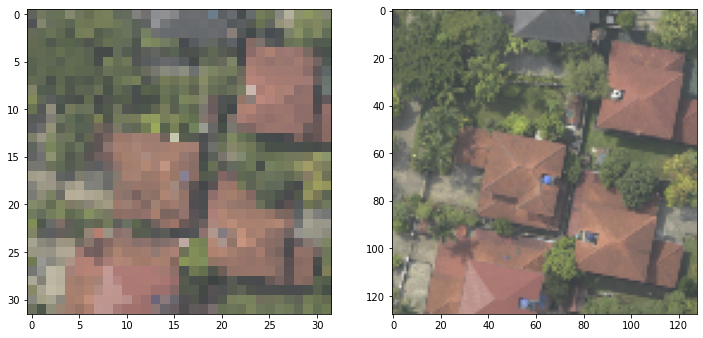

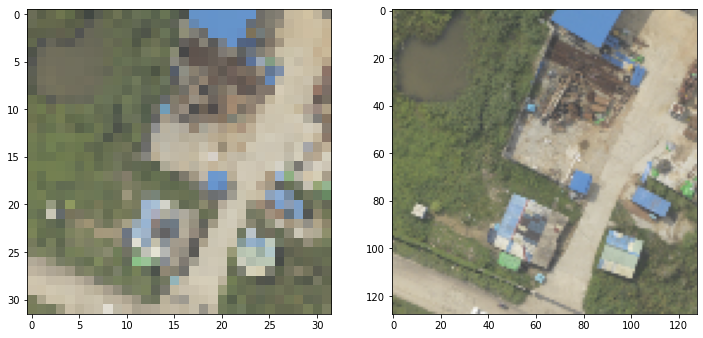

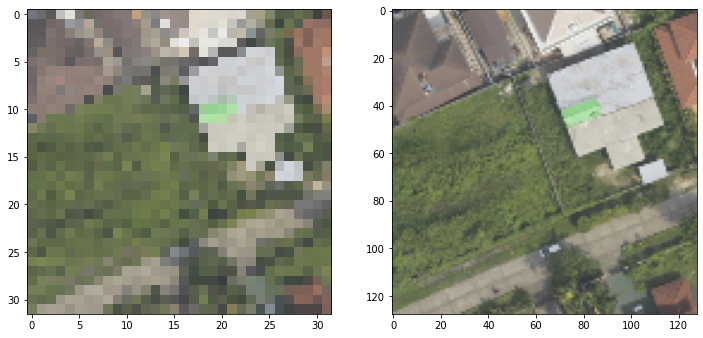

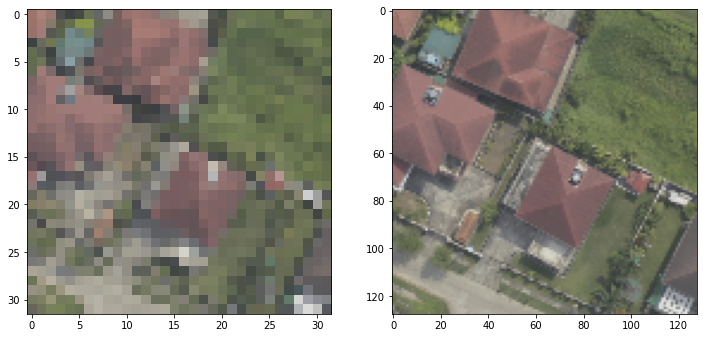

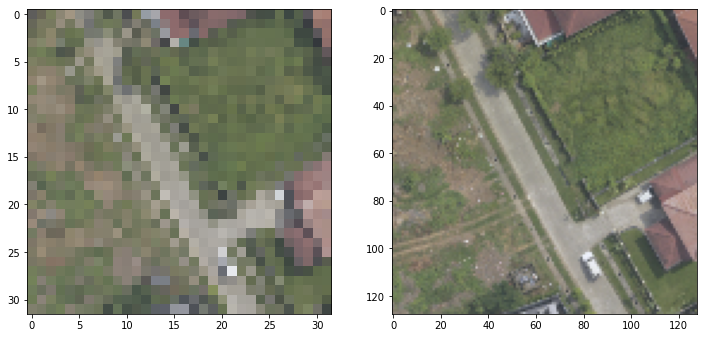

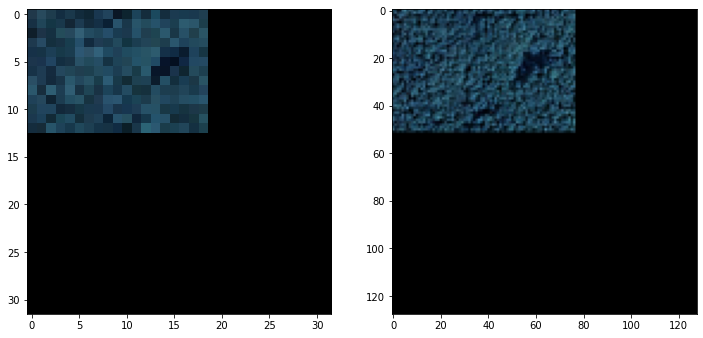

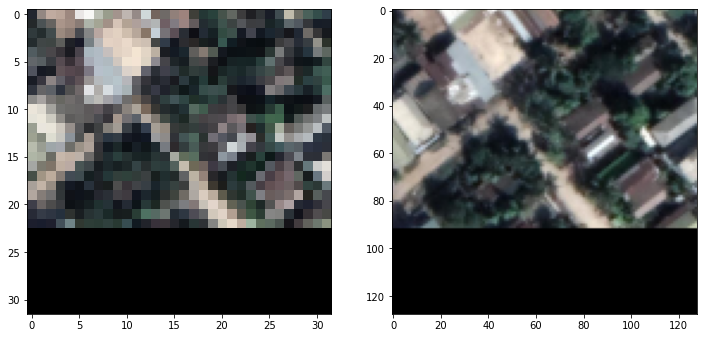

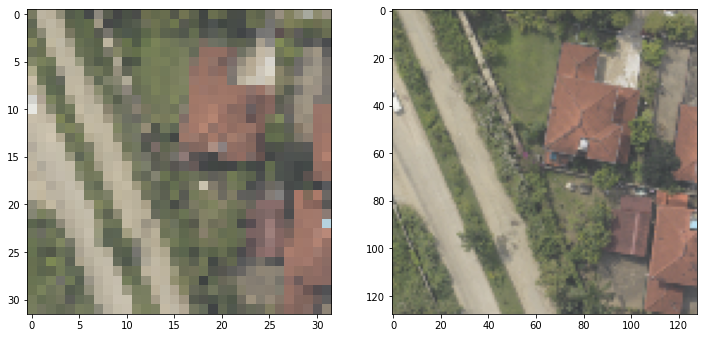

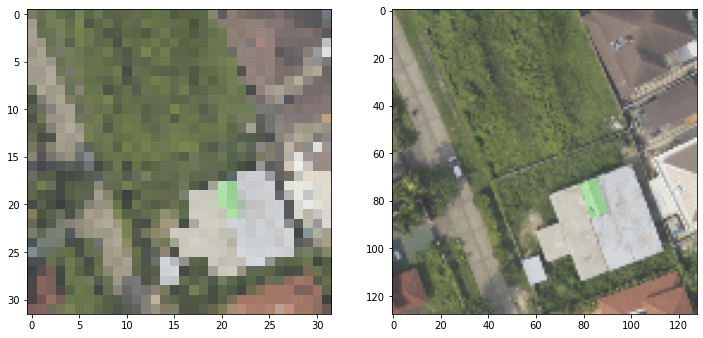

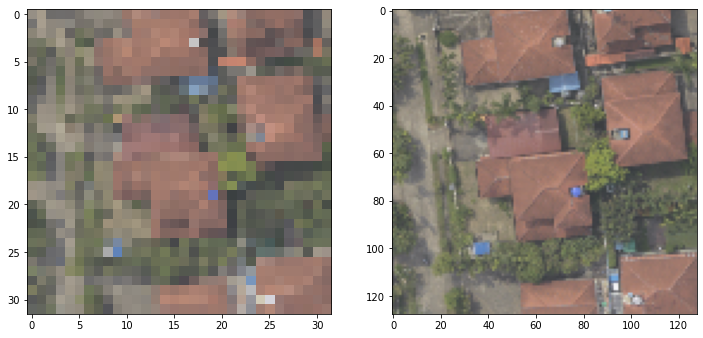

In [ ]:
###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np

for i in range(10):
  image_number = random.randint(0, len(lr_images)-1)
  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
  plt.subplot(122)
  plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
  plt.show()


In [ ]:

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
#generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
#discriminator.summary()

vgg = build_vgg((128,128,3))
#print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
#gan_model.summary()


In [ ]:

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 50
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/gen_e_"+ str(e+1) +".h5")


100%|██████████| 149/149 [00:23<00:00,  6.47it/s]


epoch: 1 g_loss: 68.57520264747158 d_loss: [3.22381077 0.77181208]


100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


epoch: 2 g_loss: 53.4582316827454 d_loss: [0.92150483 0.87583893]


100%|██████████| 149/149 [00:23<00:00,  6.34it/s]


epoch: 3 g_loss: 46.71665331821313 d_loss: [0.30258155 0.93288591]


100%|██████████| 149/149 [00:22<00:00,  6.49it/s]


epoch: 4 g_loss: 46.66491193579348 d_loss: [0.74798175 0.92281879]


100%|██████████| 149/149 [00:23<00:00,  6.46it/s]


epoch: 5 g_loss: 47.59272399364702 d_loss: [0.76421862 0.92281879]


100%|██████████| 149/149 [00:22<00:00,  6.49it/s]


epoch: 6 g_loss: 41.157675858312004 d_loss: [1.69431545 0.90604027]


100%|██████████| 149/149 [00:23<00:00,  6.42it/s]


epoch: 7 g_loss: 48.594678334741786 d_loss: [1.8019833  0.90268456]


100%|██████████| 149/149 [00:23<00:00,  6.45it/s]


epoch: 8 g_loss: 63.18143449053668 d_loss: [0.46137945 0.95973154]


100%|██████████| 149/149 [00:22<00:00,  6.53it/s]


epoch: 9 g_loss: 70.20126282608749 d_loss: [0.51866324 0.96644295]


100%|██████████| 149/149 [00:22<00:00,  6.48it/s]

epoch: 10 g_loss: 57.736401077884956 d_loss: [0.98611324 0.95637584]



100%|██████████| 149/149 [00:23<00:00,  6.45it/s]


epoch: 11 g_loss: 41.3121633913693 d_loss: [1.62262488 0.9261745 ]


100%|██████████| 149/149 [00:23<00:00,  6.40it/s]


epoch: 12 g_loss: 38.58296707972584 d_loss: [1.2875099  0.88255034]


100%|██████████| 149/149 [00:22<00:00,  6.49it/s]


epoch: 13 g_loss: 37.37427154643424 d_loss: [1.12180803 0.91610738]


100%|██████████| 149/149 [00:23<00:00,  6.47it/s]


epoch: 14 g_loss: 41.092220959247356 d_loss: [0.33786784 0.94630872]


100%|██████████| 149/149 [00:22<00:00,  6.49it/s]


epoch: 15 g_loss: 2880.4887714770016 d_loss: [0.8972716  0.94295302]


100%|██████████| 149/149 [00:22<00:00,  6.48it/s]


epoch: 16 g_loss: 98.21787589668428 d_loss: [0.02342179 0.99328859]


100%|██████████| 149/149 [00:22<00:00,  6.53it/s]


epoch: 17 g_loss: 93.01096873955439 d_loss: [0.27903811 0.98993289]


100%|██████████| 149/149 [00:22<00:00,  6.50it/s]


epoch: 18 g_loss: 73.30987226242988 d_loss: [0.60176242 0.96979866]


100%|██████████| 149/149 [00:22<00:00,  6.48it/s]


epoch: 19 g_loss: 60.738281787641895 d_loss: [0.60257709 0.97651007]


100%|██████████| 149/149 [00:22<00:00,  6.49it/s]

epoch: 20 g_loss: 53.48123878120576 d_loss: [0.73069482 0.96979866]



100%|██████████| 149/149 [00:23<00:00,  6.36it/s]


epoch: 21 g_loss: 51.85900165890687 d_loss: [0.64732376 0.96979866]


100%|██████████| 149/149 [00:22<00:00,  6.48it/s]


epoch: 22 g_loss: 49.224361496483716 d_loss: [1.55730193 0.93288591]


100%|██████████| 149/149 [00:22<00:00,  6.53it/s]


epoch: 23 g_loss: 46.648891480977106 d_loss: [1.19041389 0.95302013]


100%|██████████| 149/149 [00:22<00:00,  6.50it/s]


epoch: 24 g_loss: 46.08560153781968 d_loss: [1.2403928  0.95973154]


100%|██████████| 149/149 [00:22<00:00,  6.54it/s]


epoch: 25 g_loss: 44.93611156540429 d_loss: [0.57194629 0.96308725]


100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


epoch: 26 g_loss: 42.530575137810416 d_loss: [0.62149638 0.97986577]


100%|██████████| 149/149 [00:22<00:00,  6.52it/s]


epoch: 27 g_loss: 43.118428492706094 d_loss: [0.22987064 0.98993289]


100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


epoch: 28 g_loss: 41.776590884931935 d_loss: [0.01536382 0.9966443 ]


100%|██████████| 149/149 [00:23<00:00,  6.47it/s]


epoch: 29 g_loss: 41.766791548504926 d_loss: [0.74619118 0.97651007]


100%|██████████| 149/149 [00:22<00:00,  6.53it/s]

epoch: 30 g_loss: 40.603239680296625 d_loss: [0.25279122 0.98322148]



100%|██████████| 149/149 [00:22<00:00,  6.49it/s]


epoch: 31 g_loss: 39.926661709011 d_loss: [0.22355998 0.97986577]


100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


epoch: 32 g_loss: 40.61627307994254 d_loss: [1.49980995 0.95637584]


100%|██████████| 149/149 [00:22<00:00,  6.58it/s]


epoch: 33 g_loss: 39.83503545210665 d_loss: [0.5276665  0.98322148]


100%|██████████| 149/149 [00:22<00:00,  6.57it/s]


epoch: 34 g_loss: 39.99663886767906 d_loss: [3.92053658e-10 1.00000000e+00]


100%|██████████| 149/149 [00:22<00:00,  6.58it/s]


epoch: 35 g_loss: 38.63657352588321 d_loss: [0.36679988 0.98657718]


100%|██████████| 149/149 [00:22<00:00,  6.63it/s]


epoch: 36 g_loss: 38.84363369653689 d_loss: [1.13073179 0.95973154]


100%|██████████| 149/149 [00:22<00:00,  6.66it/s]


epoch: 37 g_loss: 39.379903780533965 d_loss: [0.23953151 0.99328859]


100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


epoch: 38 g_loss: 39.28144208536852 d_loss: [0.32841869 0.98993289]


100%|██████████| 149/149 [00:22<00:00,  6.62it/s]


epoch: 39 g_loss: 37.89236581725562 d_loss: [0.02672615 0.99328859]


100%|██████████| 149/149 [00:22<00:00,  6.60it/s]

epoch: 40 g_loss: 37.33104885664562 d_loss: [1.66773415e-11 1.00000000e+00]



100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


epoch: 41 g_loss: 36.84027135452168 d_loss: [1.83061606 0.94630872]


100%|██████████| 149/149 [00:22<00:00,  6.52it/s]


epoch: 42 g_loss: 36.14963243471696 d_loss: [0.729779   0.95637584]


100%|██████████| 149/149 [00:22<00:00,  6.48it/s]


epoch: 43 g_loss: 37.2132116740182 d_loss: [1.65154706 0.9295302 ]


100%|██████████| 149/149 [00:22<00:00,  6.52it/s]


epoch: 44 g_loss: 37.24432912928946 d_loss: [0.45534834 0.97315436]


100%|██████████| 149/149 [00:22<00:00,  6.58it/s]


epoch: 45 g_loss: 35.51460286914902 d_loss: [0.36634403 0.97315436]


100%|██████████| 149/149 [00:23<00:00,  6.45it/s]


epoch: 46 g_loss: 34.95847159264072 d_loss: [0.00945815 0.9966443 ]


100%|██████████| 149/149 [00:22<00:00,  6.50it/s]


epoch: 47 g_loss: 58.275305549570376 d_loss: [1.12806166 0.95637584]


100%|██████████| 149/149 [00:23<00:00,  6.44it/s]


epoch: 48 g_loss: 36.157003127488515 d_loss: [0.06768658 0.9966443 ]


100%|██████████| 149/149 [00:22<00:00,  6.52it/s]


epoch: 49 g_loss: 35.21544444320986 d_loss: [0.00766624 0.9966443 ]


100%|██████████| 149/149 [00:22<00:00,  6.55it/s]

epoch: 50 g_loss: 34.65483025416432 d_loss: [0.23830567 0.98657718]


74


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


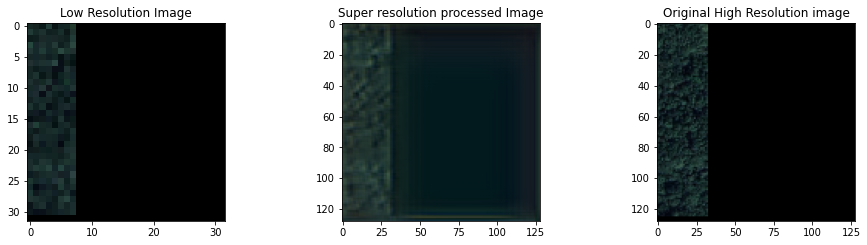

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


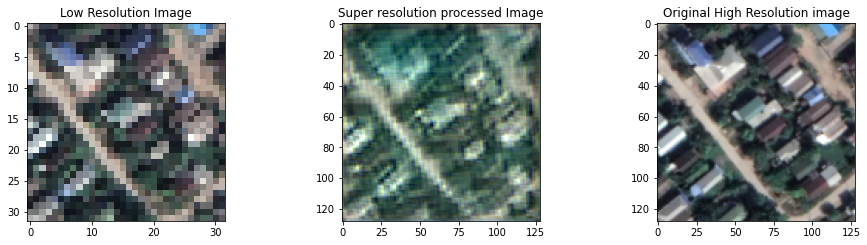

74


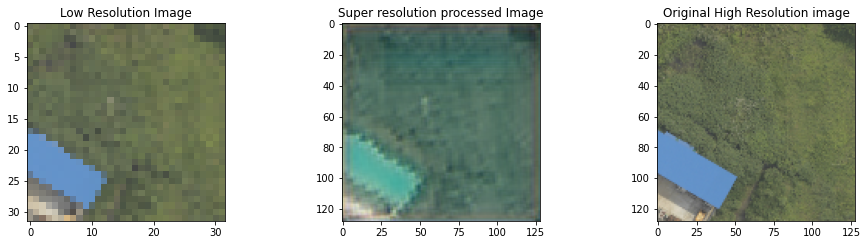

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


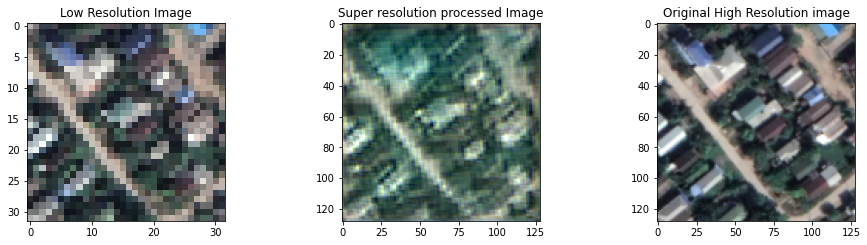

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


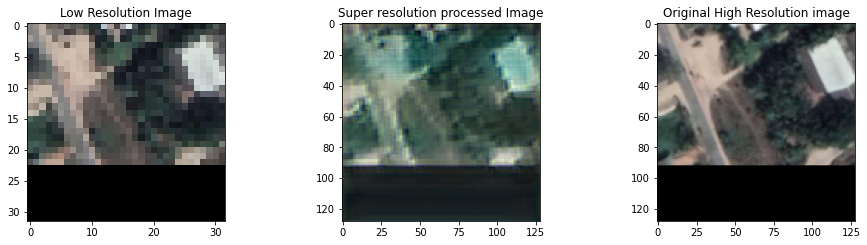

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


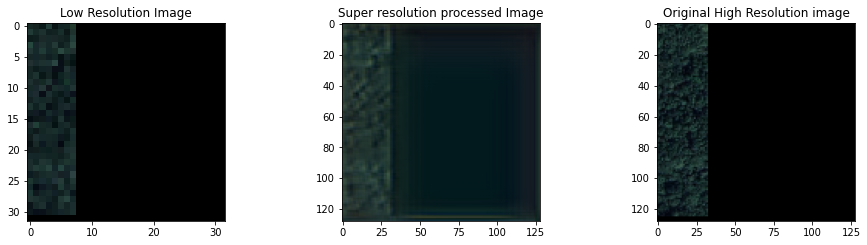

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


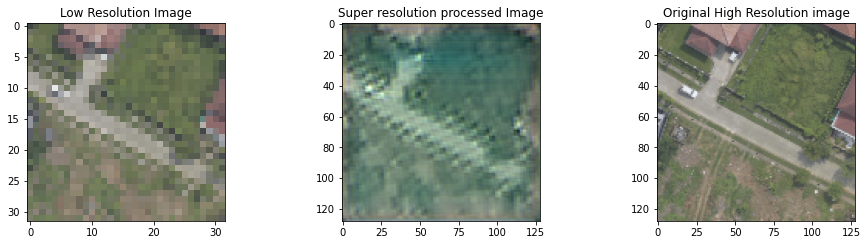

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


74


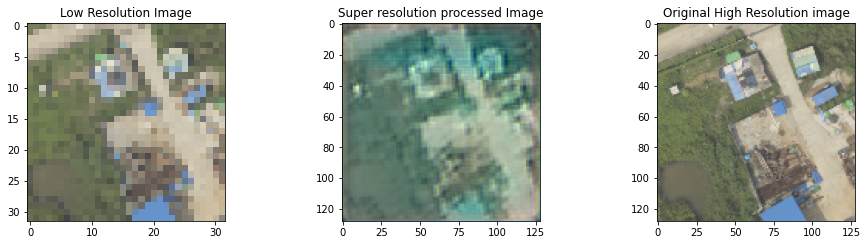

74


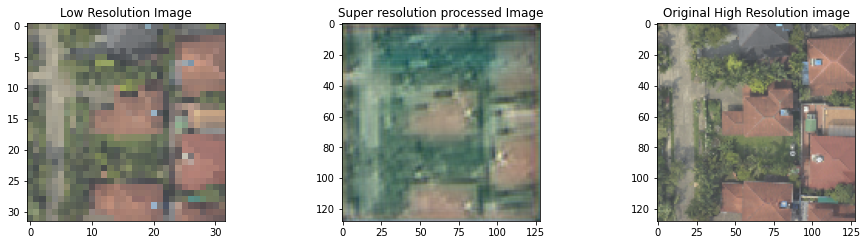

74


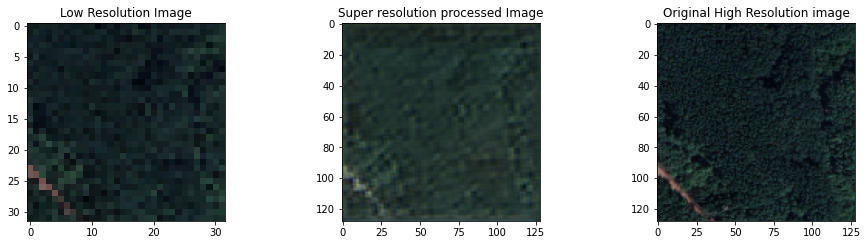

In [ ]:

###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/gen_e_40.h5', compile=False)

for i in range(10):
  [X1, X2] = [lr_test, hr_test]
  # select random example
  ix = randint(0, 20, 1)
  print(len(X1))
  src_image, tar_image = X1[ix], X2[ix]

  # generate image from source
  gen_image = generator.predict(src_image)


  # plot all three images

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Low Resolution Image')
  plt.imshow(src_image[0,:,:,:])
  plt.subplot(232)
  plt.title('Super resolution processed Image')
  plt.imshow(gen_image[0,:,:,:])
  plt.subplot(233)
  plt.title('Original High Resolution image')
  plt.imshow(tar_image[0,:,:,:])
  plt.savefig('/content/preds/predictions'+str(i)+'.png')
  plt.show()
